# **C3S Soil Moisture Data Access and Anomaly Analysis Notebook**

In this tutorial we will:
- download C3S Satellite Soil Moisture data from the [Copernicus Climate Data Store (CDS)](https://doi.org/10.24381/cds.d7782f18)
- read data stacks in python using [xarray](https://docs.xarray.dev/en/stable/) 
- perform simple analyses of soil moisture anomalies over selected study areas. 

Related tutorials:
- [Climate Data Store Tutorial (general overview)](https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html)

Prior knowledge of python is recommended for this tutorial. Ideally you have a basic understanding of the python programming language, and have already worked with libraries such as [xarray](https://docs.xarray.dev/en/stable/), [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/). Please visit the [CDS Soil moisture page](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-soil-moisture?tab=overview) to get an overview over the available C3S soil moisture datasets and related documentation.

# Outline
The tutorial consists of the following main steps:
1. [Setup](#setup)
2. [A short description of the data sets](#about)
3. [Download satellite soil moisture images from CDS using the CDS API](#access)
4. [Application 1: Open downloaded data and visualize the soil moisture variable](#read)
5. [Application 2: Extract a time series for a single location and compute the soil moisture anomaly](#anom1d)
6. [Application 3: Vectorized anomaly computation and data extraction for a study area](#anomNd)


The tutorial can be run in Binder, an online platform that provides an executable environment. This allows anyone to run the code directly and reproduce the results without needing to install any software or set up the environment locally.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Click on the badge to run the tutorial via free cloud platforms (might take a few minutes to load): </th>
    <th><a href="https://mybinder.org/v2/gh/TUW-GEO/c3s_sm-tutorials/v1.2?labpath=T1_DataAccess_Anomalies.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
  </tr>
</table>

<br><br>

*Note: Cells in this notebook should be executed **in order** (from top to bottom). Some of the later examples depend on previous ones!*

<a id='setup'></a>
## 1. Setup
First we ensure that the [CDS API](https://pypi.org/project/cdsapi/) is installed by running the following command using `pip`:

In [1]:
%%capture --no-display
!pip install cdsapi

In the next cell we import all libraries necessary to run code in this notebook. Some of them are python standard libraries, that are installed by default. If you encounter any errors during import, you can install missing packages using the [`conda` package manager](https://docs.conda.io/en/latest/) via:
```
!conda install -y -c conda-forge <PACKAGE>
```
A full list of dependencies required to run this notebook is available in the `environment.yml` file at https://github.com/TUW-GEO/c3s_sm-tutorials. If you are on Binder or any other cloud platform, all necessary dependencies are already installed.

In [2]:
import os  # Provides functions to interact with the operating system (e.g., file and directory management)
import cdsapi  # Allows interaction with the Climate Data Store (CDS) API to download climate data
from pathlib import Path  # Offers an object-oriented approach to handle filesystem paths
import matplotlib.pyplot as plt  # Used for creating static, animated, and interactive visualizations in Python
import cartopy  # Provides tools for cartographic projections and geospatial data visualization
import cartopy.crs as ccrs  # Used to handle coordinate reference systems in Cartopy maps
import xarray as xr  # Facilitates working with labeled multi-dimensional arrays, particularly in the context of climate data
import shutil  # Allows high-level operations on files and collections of files, such as copying and removing files
import pandas as pd  # Provides powerful data structures like DataFrames for data manipulation and analysis
import numpy as np  # Supports large, multi-dimensional arrays and matrices, along with a collection of mathematical functions
import zipfile  # Enables reading and writing of ZIP archive files
from collections import (
    OrderedDict,
)  # Preserves the order of items in a dictionary (used when the order of elements is important)
from matplotlib.lines import (
    Line2D,
)  # Used to create and customize line objects in Matplotlib plots
import matplotlib.colors as colors  # Manages color maps and normalizing data values to colors in Matplotlib
import warnings  # Provides a way to issue warning messages and control their visibility

warnings.filterwarnings("ignore")  # Suppresses warnings from appearing in the output

%matplotlib inline

We also define a color map that we will use later for plotting the soil moisture data.

In [3]:
CM_SM = colors.LinearSegmentedColormap.from_list(
    "BrownBlue",
    np.array(
        [
            [134, 80, 16],
            [164, 117, 13],
            [219, 190, 24],
            [250, 249, 156],
            [144, 202, 240],
            [4, 145, 251],
            [8, 83, 211],
            [13, 37, 161],
        ]
    )
    / 255.0,
)

<a id='about'></a>

## 2. About C3S Satellite Soil Moisture
Satellite sensors are capable of observing the water content in the top soil layer from space. Various satellite missions from different space agencies provide measurements of radiation from the Earth's surface across different (microwave) frequency domains (e.g. Ku-, X-, C-, and L-band). These (raw) measurements are closely linked to the amount of water stored in the soil. There are two types of sensors that are used to measure this information: passive systems (radiometer) and active systems (radar).

<center><img src="img/act_pass.png" width="35%"/></center>

For a detailed description, please see the C3S Soil Moisture Algorithm Theoretical Baseline Document, which is available along with the data on the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.d7782f18).

### 2.1 Soil moisture from radiometer measurements (PASSIVE)
Brightness temperature is the observable of passive sensors (expressed in $°K$). It is a function of kinetic temperature and emissivity. Wet soils have a higher emissivity than dry soils and therefore a lower brightness temperature. Passive soil moisture retrieval uses this difference between the kinetic temperature and brightness temperature to model the amount of water available in the soil of the observed area, while taking into account factors such as the water held by vegetation.

NASA's SMAP and ESA's SMOS satellites are examples for L-band radiometer missions. They are suitable for retrieving soil moisture globally, even when vegetation is present in a scene.

Different models to retrieve Soil Moisture from brightness temperature measurements exist. One of the them is the Land Parameter Retrieval Model ([Owe et al., 2008](https://doi.org/10.1029/98WR01469), [Owe et al., 2001](https://doi.org/10.1109/36.942542), and [van der Schalie et al., 2016](https://doi.org/10.1016/j.jag.2015.08.005)). This model is used to derive soil moisture for all passive sensors in C3S.

The PASSIVE product of C3S Soil Moisture contains merged observations from passive systems **only**. It is given in volumetric units $[m^3 / m^3]$.

### 2.2 Soil moisture from scatterometer measurements (ACTIVE)
Active systems emit radiation in the microwave domain (C-band in C3S). As the energy pulses emitted by the radar hit the Earth's surface, a scattering effect occurs and part of the energy is reflected back, containing information on the surface state of the observed scene. The received energy is called “backscatter”, with rough and wet surfaces producing stronger signals than smooth or dry surfaces. Backscatter comprises reflections from the soil surface layer (“surface scatter”), vegetation (“volume scatter”) and interactions of the two. 

ESA's ERS-1 and ERS-2, as well as EUMETSAT's Metop ASCAT sensors are active systems used in C3S soil moisture. In the case of Metop ASCAT, C3S Soil Moisture uses the Surface Soil Moisture products directly provided by [H SAF](https://hsaf.meteoam.it/), based on the WARP algorithm ([Wagner et al., 1999](https://doi.org/10.1016/S0034-4257(99)00036-X), [Wagner et al., 2013](https://publik.tuwien.ac.at/files/PubDat_217985.pdf)).

The ACTIVE product of C3S Soil Moisture contains merged observations from active systems **only**. It is given in relative units $[\%$ $saturation]$.

### 2.3 Merged product (COMBINED)

Single-sensor products are limited by the life time of the satellite sensors. Climate change assessments, however, require the use of long-term data records, that span over multiple decades and provide consistent and comparable observations. The C3S Soil Moisture record therefore merges the observations from more than 15 sensors into one harmonized record. The main two steps of the product generation include scaling all sensors to a common reference, and subsequently merging them by applying a weighted average, where sensor with a lower error are assigned a higher weight. 

The following figure shows all satellite sensors merged in the PASSIVE (only radiometers), ACTIVE (only scatterometers) and COMBINED (scatterometers and radiometers) C3S product (data set version v202212).

<center><img src="img/sensors.png" width="70%"/></center>

C3S Soil Moisture is based on the ESA CCI SM algorithm, which is described in [Dorigo et al., 2017](https://doi.org/10.1016/j.rse.2017.07.001.) and [Gruber et al., 2019](https://doi.org/10.5194/essd-11-717-2019).

The COMBINED product is also given in volumetric units $[m^3 / m^3]$. However, the absolute values depend on the scaling reference, which is used to bring all sensors into the same dynamic range. In this case we use soil moisture simulations for the first 10 cm from the GLDAS Noah model ([Rodell et al., 2004](https://doi.org/10.1175/BAMS-85-3-381)).



<a id='access'></a>

## 3. Data Access and Download
Different products and versions for C3S Soil Moisture are available on the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/#!/home). In general, there are 2 types of data records:
 - **CDR**: The long term Climate Data Record, processed every 1-2 years, contains data for more than 40 years, but not up-to-date.
 - **ICDR**: Interim Climate Data Record, updated every 10-20 days, extends the CDR, contains up-to-date (harmonised) observations to append to the CDR.

### 3.1 Creating a valid CDS data request for satellite soil moisture
There are different options to specify a valid C3S Soil Moisture CDS data download request. You can use the [CDS GUI](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-soil-moisture?tab=form) to generate a valid request (button at the bottom of the page:`Show API Request`) and copy/paste it into your python script as shown below. To summarize the options:

- **`variable`**: either `volumetric_surface_soil_moisture` (must be chosen to download the PASSIVE or COMBINED data) or `surface_soil_moisture` (required for ACTIVE product)
- **`type_of_sensor`**: `active`, `passive` and/or `combined_passive_and_active` (must match with the selected variable!)
- **`time_aggregation`**: `month_average`, `10_day_average`, or `day_average`. The original data is daily. Monthly and 10-daily averages are often required for climate analyses and therefore provided for convenience.
- **`year`**: a list of years to download data for (COMBINED and PASSIVE data is available from **1978** onward, ACTIVE starts in **1991**)
- **`month`**: a list of months to download data for.
- **`day`**: a list of days to download data for (note that for the monthly data, `day` must always be '01'. For the 10-daily average, valid `days` are: '01', '11', '21' (therefore the day always refers to the start of the period the data represents).
- **`type_of_record`**: `cdr` and/or `icdr`. It is recommended to select both, to use whichever data is available (there is no overlap between ICDR and CDR of a major version).
- **`version`**: Data record version, currently available: `v201706`, `v201812`, `v201812`, `v201912`, `v202012`(as of June 2023; new versions are added regularly). Sub-versions indicate new data that is meant to replace the previous sub-versions (necessary e.g. due to processing errors). It is therefore recommended to pass all sub-versions and use the file with the highest version for any time stamp in case of duplicate time stamps.
- **`format`**: Either `zip` or `tgz`. Archive format that holds the individual netcdf images.

### 3.2 Getting your CDS API Key
In order to download data from the Climate Data Store (CDS) via the API you need:
1) An account at https://cds.climate.copernicus.eu
2) A personal API key. To retrieve you key, see the description [here](https://cds.climate.copernicus.eu/api-how-to) and [this tutorial](https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html)

If you do not provide a valid KEY in the next cell, the following API request will fail. However, you can then still continue with the example data provided together with this notebook, which is the same data you would get if the query is not changed: i.e., monthly volumetric surface soil moisture from passive observations at version *v202012* over Europe, from CDR & ICDR. The provided example data is stored in the repository as this notebook (`./DATA/sm_monthly_passive_v202012.zip`). It is recommended to use **monthly** data, as some of the examples in this notebook will not work with daily or 10-daily images!

In [4]:
URL = "https://cds.climate.copernicus.eu/api/v2"
# If you have a valid key, set it in the following line:
KEY = "#######################################"

In this cell we submit a data request. This will only succeed if
- a valid KEY was defined in the previous cell
- a valid request is made (the default request here is valid).

Otherwise the data request will fail. However, this is not a problem for this tutorial. We will just fall back to the data provided with this notebook.

### 3.3 Creating a data path to our downloaded data
In the next cells we create a variable `DATA_PATH` which points to a .zip archive (either newly downloaded or the one provided with this tutorial) containing the selected data from CDS as individual images.

In [5]:
# Specify some filename and directories to handle the data
DATADIR = "./data_dir"
os.makedirs(DATADIR, exist_ok=True)
# Filename for the zip file downloaded from the CDS
download_zip_file = os.path.join(DATADIR, "sm_monthly_passive_v202012.zip")
# Filename for the netCDF file which contain the merged contents of the monthly files.
merged_netcdf_file = os.path.join(DATADIR, "sm_monthly_passive_v202012.nc")

In [6]:
# If we have not downloaded the zip file, we make the data request via the cdsapi
if not os.path.isfile(download_zip_file):
    c = cdsapi.Client(url=URL, key=KEY)
    c.retrieve(
        "satellite-soil-moisture",
        {
            "variable": "volumetric_surface_soil_moisture",
            "type_of_sensor": "passive",
            "time_aggregation": "month_average",  # required for examples in this notebook
            "year": [str(y) for y in range(1991, 2023)],
            "month": [f"{m:02}" for m in range(1, 13)],
            "day": "01",
            "area": [72, -11, 34, 40],
            "type_of_record": ["cdr", "icdr"],
            "version": ["v202012"],
            "format": "zip",
        },
        download_zip_file,
    )
else:
    print(f"Using previously downloaded file: {download_zip_file}")

Using previously downloaded file: ./data_dir/sm_monthly_passive_v202012.zip


### 3.4 Unpacking and pre-processing the Data
In the next cell we extract all files from the downloaded .zip archive into a new folder. We do this using standard python libraries. This step might take up to 1 minute to process during first execution!

In [7]:
if not os.path.isfile(merged_netcdf_file):
    # Unzip the data. The dataset is split in monthly files.
    with zipfile.ZipFile(download_zip_file, "r") as zip_ref:
        filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
        zip_ref.extractall(DATADIR)
    # Ensure the filelist is in the correct order:
    filelist = sorted(filelist)

    # Merge all unpacked files into one.
    # We do this in batches of 100 files to avoid issues with dask
    new_filelist = []
    for i in range(int(len(filelist) / 100.0) + 1):
        temp_fname = os.path.join(DATADIR, f"temp_file_{i}.nc")
        new_filelist += [temp_fname]
        ds = xr.open_mfdataset(filelist[i * 100 : (i * 100) + 100])
        ds.to_netcdf(temp_fname)

    ds = xr.open_mfdataset(new_filelist)
    ds.to_netcdf(merged_netcdf_file)
    # Recursively delete unpacked data
    for f in filelist:
        os.remove(f)
    for f in new_filelist:
        os.remove(f)

    print(f"Preprocessing done. Netcdf stack now available at: {merged_netcdf_file}")
else:
    print(f"No preprocessing required. Netcdf stack already available at: {merged_netcdf_file}")

No preprocessing required. Netcdf stack already available at: ./data_dir/sm_monthly_passive_v202012.nc


### 3.5 Loading Data with xarray
We will use the library [xarray](https://docs.xarray.dev/en/stable/) to read the data. We can use the function [xarray.open_mfdataset](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html) to load all extracted files and concatenate them along the 'time' dimension automatically. This way we get a 3-dimensional (longitude, latitude, time) data cube, that we store in a global variable `DS`. In addition we extract the unit and valid range of the soil moisture variable from the netCDF metadata (`SM_UNIT` and `SM_RANGE`).

In [8]:
DS = xr.open_mfdataset(merged_netcdf_file)
SM_UNIT = DS["sm"].attrs["units"]
SM_RANGE = DS["sm"].attrs["valid_range"]

Finally we plot a table that shows the contents of `DS`. You can see the dimensions of the data cube, coordinates assigned to each dimension, and data variables (each data point has coordinates assigned for each dimension). You can also explore the 'Attributes' field (i.e. metadata assigned to the data cube) by clicking on it.

In [9]:
DS

<xarray.Dataset> Size: 191MB
Dimensions:     (lat: 152, lon: 204, time: 384)
Coordinates:
  * lat         (lat) float32 608B 71.88 71.62 71.38 71.12 ... 34.62 34.38 34.12
  * lon         (lon) float32 816B -10.88 -10.62 -10.38 ... 39.38 39.62 39.88
  * time        (time) datetime64[ns] 3kB 1991-01-01 1991-02-01 ... 2022-12-01
Data variables:
    sm          (time, lat, lon) float32 48MB dask.array<chunksize=(192, 76, 102), meta=np.ndarray>
    sensor      (time, lat, lon) float32 48MB dask.array<chunksize=(192, 76, 102), meta=np.ndarray>
    freqbandID  (time, lat, lon) float32 48MB dask.array<chunksize=(192, 76, 102), meta=np.ndarray>
    nobs        (time, lat, lon) float32 48MB dask.array<chunksize=(192, 76, 102), meta=np.ndarray>
Attributes: (12/40)
    title:                      C3S Surface Soil Moisture merged PASSIVE Product
    institution:                EODC (AUT); TU Wien (AUT); VanderSat B.V. (NL)
    contact:                    C3S_SM_Science@eodc.eu
    source:                     LPRMv6/SMMR/Nimbus 7 L3 Surface Soil Moisture...
    platform:                   Nimbus 7, DMSP, TRMM, AQUA, Coriolis, GCOM-W1...
    sensor:                     SMMR, SSM/I, TMI, AMSR-E, WindSat, AMSR2, SMO...
    ...                         ...
    id:                         C3S-SOILMOISTURE-L3S-SSMV-PASSIVE-MONTHLY-199...
    history:                    2021-03-29T13:46:57.630282 mean calculated
    date_created:               2021-03-29T13:46:57Z
    time_coverage_start:        1990-12-31T12:00:00Z
    time_coverage_end:          1991-01-31T12:00:00Z
    time_coverage_duration:     P1M

<a id='read'></a>

## 4. **Application 1**: Data Visualization
Now that we have a data cube (`DS`) to work with, we can start by visualizing some of the monthly soil moisture values. Our data cube `DS` is an [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html), which comes with a lot of functionalities. For example we can create a simple map visualization of:
- soil moisture for a certain date. 
- the number of observations for a certain date (note that `nobs` is only available for monthly and 10-daily averaged data downloaded from CDS). 
Here we extract an image from the data cube using the [xarray.Dataset.sel](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html) method. 

In the next cell, you can select a date to plot soil moisture data. 
We then select the correct soil moisture (and observation count) data and create a map visualization.

Try:
- Choosing a different month and year in the first line, to plot the data for a different time stamp.

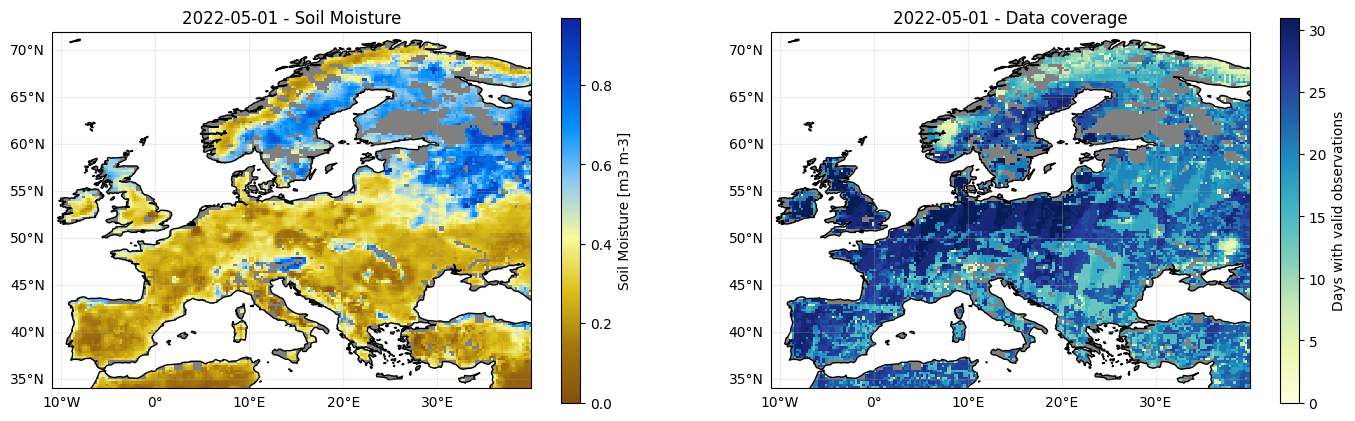

In [10]:
DATE = "2022-05-01"  # Time stamp to create plot for, you can choose a different date!

# Check whether the above selected date is available
_dates = [str(pd.to_datetime(t).date()) for t in DS["time"].values]
if DATE not in _dates:
    raise KeyError(f"{DATE} not found in data. " f"Select one of {_dates}")

# Create an empty figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(17, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# Extract and plot the soil moisture image for chosen date using xarray.Dataset.sel and Dataset.plot:
p_sm = (
    DS["sm"]
    .sel(time=DATE)
    .plot(
        transform=ccrs.PlateCarree(),
        ax=axs[0],
        cmap=CM_SM,
        cbar_kwargs={"label": f"Soil Moisture [{SM_UNIT}]"},
    )
)
axs[0].set_title(f"{DATE} - Soil Moisture")


# Extract and plot the number of observations (nobs) image for chosen date using xarray.Dataset.sel and Dataset.plot:
if "nobs" in DS.variables:
    # Note: nobs is only available for monthly and 10-daily data
    p_obs = (
        DS["nobs"]
        .sel(time=DATE)
        .plot(
            transform=ccrs.PlateCarree(),
            ax=axs[1],
            vmax=31,
            vmin=0,
            cmap=plt.get_cmap("YlGnBu"),
            cbar_kwargs={"label": "Days with valid observations"},
        )
    )
    axs[1].set_title(f"{DATE} - Data coverage")
else:
    p_obs = None


# Add basemape features:
for p in [p_sm, p_obs]:
    if p is None:
        continue
    p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor="gray")
    p.axes.coastlines()

# Draw grid lines and labels for both maps:
for ax in axs:
    if ax is not None:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.25)
        gl.top_labels, gl.right_labels = False, False

plt.show()  # Draw the figure

When looking at images of different dates, you can see data gaps (gray areas; especially in winter, mountainous regions and high latitude) and areas of high (blue) and low (brown) soil moisture content (left map). When changing the date to plot in the cell above, you can seen that the number of observations is much larger in later periods of the record than in earlier ones due to the larger number of available satellites (right map).

<a id='anom1d'></a>

## 5. **Application 2**: Time Series Extraction and Analysis

In the following two examples we will need to set a study area and a time range. We will use a chosen 'focus point' assigned to the study area to extract a time series from the loaded stack at this location. 

<a id='study_areas'></a>
### 5.1 Study areas
First we define some potential study areas that we can use in the following applications. Below you can find a list of bounding boxes, plus one 'focus point' in each bounding box. You can add your own study area to the end of the list. If you do, make sure to pass the coordinates in the correct order: Each line consists of:

- A name for the study area
- WGS84 coordinates of corner points of a bounding box around the study area
- WGS84 coordinates of a single point in the study area (focus area)

`(<STUDY_AREA_NAME>, ([<BBOX min. Lon.>, <BBOX max. Lon.>, <BBOX min. Lat.>, <BBOX max. Lat.>], [<POINT Lon.>, <POINT Lat.>]))`

In [11]:
BBOXES = OrderedDict(
    [
        # (Name, ([min Lon., max Lon., min Lat., max Lat.], [Lon, Lat])),
        ("Balkans", ([16, 29, 36, 45], [24, 42])),
        ("Cental Europe", ([6, 22.5, 46, 51], [15, 49.5])),
        ("France", ([-4.8, 8.4, 42.3, 51], [4, 47])),
        ("Germany", ([6, 15, 47, 55], [9, 50])),
        ("Iberian Peninsula", ([-10, 3.4, 36, 44.4], [-5.4, 41.3])),
        ("Italy", ([7, 19.0, 36.7, 47.0], [12.8, 43.4])),
        ("S-UK & N-France", ([-5.65, 2.5, 48, 54], [0, 51])),
    ]
)

#### 5.1.1 Visual representation study area
We will visualize the absolute monthly soil moisture values for a certain date, as we did in 'Application 1: data visualization'. In addition, we will show the selected study area together with the data on a map. we will also show chosen 'focus point' assigned to the study area, marked by the red <span style="color: red;">X</span>.

Try:
- Choosing a different study area by changing the `STUDY_AREA` variable.

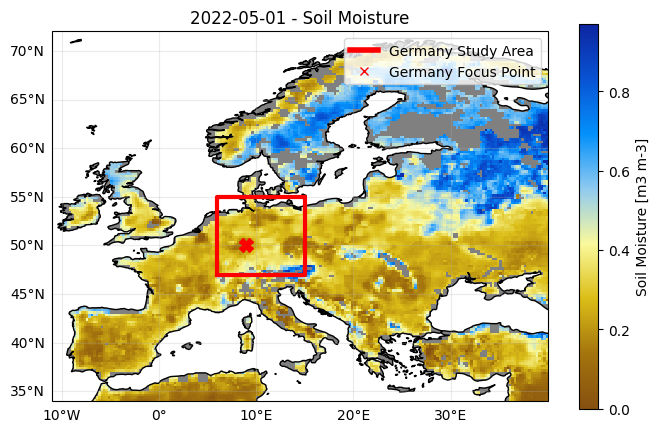

In [12]:
DATE = "2022-05-01"  # Time stamp to create plot for, you can choose a different date!
STUDY_AREA = "Germany"  # Specify the study area (ensure it's in BBOXES)

# Check whether the selected study area and date are available
if STUDY_AREA not in BBOXES:
    raise KeyError(f"Unknown STUDY_AREA: {STUDY_AREA}. Select one of {BBOXES.keys()}")
_dates = [str(pd.to_datetime(t).date()) for t in DS["time"].values]
if DATE not in _dates:
    raise KeyError(f"{DATE} not found in data. Select one of {_dates}")


# Create a figure with a specific size and a single axis
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())  # Create a single axis with a cartopy projection

# Extract and plot soil moisture image for the chosen date using xarray.Dataset.sel and Dataset.plot
p_sm = (
    DS["sm"]
    .sel(time=DATE)
    .plot(
        transform=ccrs.PlateCarree(),
        ax=ax,
        cmap=CM_SM,
        cbar_kwargs={"label": f"Soil Moisture [{SM_UNIT}]"},
    )
)
ax.set_title(f"{DATE} - Soil Moisture")

# Add basemap features
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor="gray")
ax.coastlines()

# Draw grid lines and labels for the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.25)
gl.top_labels, gl.right_labels = False, False

bbox = BBOXES[STUDY_AREA][0]
point = BBOXES[STUDY_AREA][1]

# Add focus point of study area to the map
ax.plot(
    [point[0]],
    [point[1]],
    color="red",
    marker="X",
    markersize=10,
    transform=ccrs.PlateCarree(),
)

# Add study area bounding box to the map
ax.plot(
    [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
    [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
    color="red",
    linewidth=3,
    transform=ccrs.PlateCarree(),
)

# Add study area legend
ax.legend(
    handles=[
        Line2D([0], [0], color="r", lw=4, label=f"{STUDY_AREA} Study Area"),
        Line2D([0], [0], lw=0, marker="x", color="r", label=f"{STUDY_AREA} Focus Point"),
    ]
)

plt.show()  # Display the plot

### 5.2 Extracting the time series data

We use the chosen 'focus point' assigned to the study area (marked by the red <span style="color: red;">X</span> in the  map above) to extract a time series from the loaded stack at this location. We then compute the climatological mean (and standard deviation) for the chosen time series using the selected reference period (baseline). Finally, we subtract the climatology from the absolute soil moisture to derive a time series of anomalies. Anomalies therefore indicate the deviation of a single observation from the average (normal) conditions. A positive anomaly can be interpreted as "wetter than usual" soil moisture conditions, while a negative anomaly indicates "drier than usual" states.

#### 5.2.1 Expressing anomalies

There are different ways to express anomalies. For example:
1) **Absolute Anomalies**: Derived using the difference between the absolute values for a month ($i$) and year ($k$) ($SM_{k,i}$) and the climatology for the same month ($SM_i$). Same unit as the input data.

    <center>$\Large SMA_{k,i}^{abs} = SM_{k,i} - \overline{SM_i}$</center><br>

2) **Relative Anomalies**: The anomalies are expressed relative to the climatological mean for a month ($SM_i$), i.e. in \% above / below the expected conditions.

    <center>$\Large SMA_{k,i}^{rel}=\frac{SM_{k,i} - \overline{SM_i}}{\overline{SM_i}} \cdot 100\% $</center><br>


3) **Z-Scores**: Z-scores are a way of standardizing values from different normal distributions. In the case of soil moisture, the spread of values between months can vary, e.g. due to differences in data coverage (i.e. a different distribution for values in summer than for those in winter is expected). This can affect the computed climatology and therefore the derived anomalies. By taking into account the standard deviation ($\sigma$) of samples used to compute the climatologies, we can normalize the anomalies and exclude this effect. Z-scores therefore express the number of standard deviations a value is above / below the expected value for a month.

    <center>$\Large Z_{k,i} = \frac{SM_{k,i} - \overline{SM_i}}{\sigma_{i}}$</center><br>

Note: The anomaly formulas are presented in Jupyter Notebook format and may not be viewable in a standard web browser.

### 5.3 Application extracting the time series data

First we extract a time series for the chosen 'focus point' of the study area (see location in the map of the previous example) and a chosen reference period.

Try:
- Choosing a different study area by changing the `STUDY_AREA` variable. See section 5.1 Study areas for your options.
- Choosing a different reference period by changing the `BASELINE_YEARS` variable. The first value is the start year of the reference period, the second values is the last year that is considered when computing the climatological reference.

In [13]:
BASELINE_YEARS = (1991, 2020)  # First and last year to consider for climatology, can be changed.
STUDY_AREA = "Germany"  # Try out a differen study area


# Extract data at the 'focus point' of the chosen study area:
lon, lat = float(BBOXES[STUDY_AREA][1][0]), float(BBOXES[STUDY_AREA][1][1])
ts = DS["sm"].sel(lon=lon, lat=lat, method="nearest").to_pandas()

# Select the time series only for the baseline years and save it as clim_data:
time_series_data = ts.loc[f"{BASELINE_YEARS[0]}-01-01" :f"{BASELINE_YEARS[1]}-12-31"]

We plot the extracted soil moisture time series, for our chosen reference years and study area:

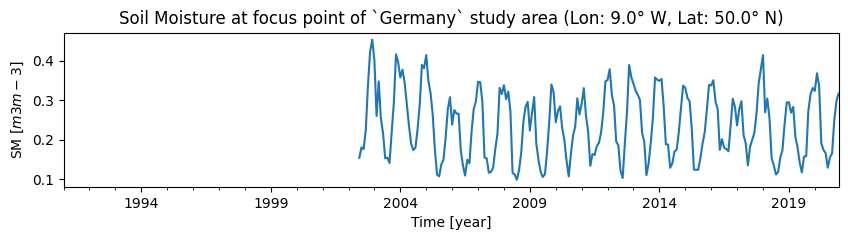

In [14]:
# Create a figure with a specific size
plt.figure(figsize=(10, 2))

# Plot the soil moisture time series
time_series_data.plot(
    title=f"Soil Moisture at focus point of `{STUDY_AREA}` study area (Lon: {lon}° W, Lat: {lat}° N)",
    ylabel=f"SM $[{SM_UNIT}]$",
    xlabel="Time [year]",
)

# Show the plot
plt.show()

We use the time series data to compute the climatological mean and standard deviation for the chosen time series using the selected reference period (baseline):

In [15]:
# Compute the required statistics:
clim_mean = pd.Series(
    time_series_data.groupby(time_series_data.index.month).mean(), name="climatology"
)
clim_std = pd.Series(
    time_series_data.groupby(time_series_data.index.month).std(), name="climatology_std"
)

# Save the Climatology data in the time series data frame
ts = pd.DataFrame(time_series_data, columns=["sm"])
ts["climatology"] = ts.join(on=ts.index.month, other=clim_mean)["climatology"]
ts["climatology_std"] = ts.join(on=ts.index.month, other=clim_std)["climatology_std"]

Create a plot for the climatology - the mean and standard deviation for each month in the chosen baseline period:

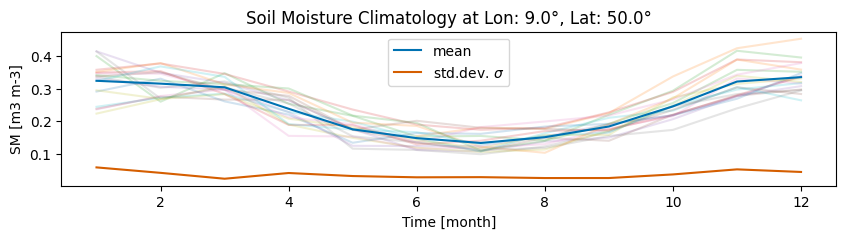

In [16]:
# Create a figure with a specific size and a single axis
plt.figure(figsize=(10, 2))
ax = plt.gca()
color_mean = "#0072B2"  # Blue
color_std = "#D55E00"  # Orange

# Plot each year's data with transparency
for i, g in time_series_data.groupby(time_series_data.index.year):
    ax.plot(range(1, 13), g.values, alpha=0.2)

# Plot the climatology mean and standard deviation
clim_mean.plot(
    ax=ax,
    color=color_mean,
    title=f"Soil Moisture Climatology at Lon: {lon}°, Lat: {lat}°",
    ylabel=f"SM [{SM_UNIT}]",
    label="mean",
)
clim_std.plot(ax=ax, color=color_std, label="std.dev. $\sigma$", xlabel="Time [month]")

# Add the legend
ax.legend()

# Show the plot
plt.show()

Using the above formulas (section 5.2.1 Expressing anomalies), we compute the three anomaly metrics for the extracted time series and store them in a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) (columns 'abs_anomaly', 'rel_anomaly' and 'z-score'):

In [17]:
# Compute the anomaly metrics
ts["abs_anomaly"] = ts["sm"] - ts["climatology"]
ts["rel_anomaly"] = (ts["sm"] - ts["climatology"]) / ts["climatology"] * 100
ts["z_score"] = (ts["sm"] - ts["climatology"]) / ts["climatology_std"]

# Save anomaly metrics in pandas DataFrame
metrics = ["Absolute Anomalies", "Relative Anomalies", "Z-Scores"]
columns = ["abs_anomaly", "rel_anomaly", "z_score"]
ylabels = [f"Anomaly $[{SM_UNIT}]$", "Anomaly $[\%]$", "Z-score $[\sigma]$"]

Now we create a plot for each anomaly metric derived from the extracted time series and climatology:

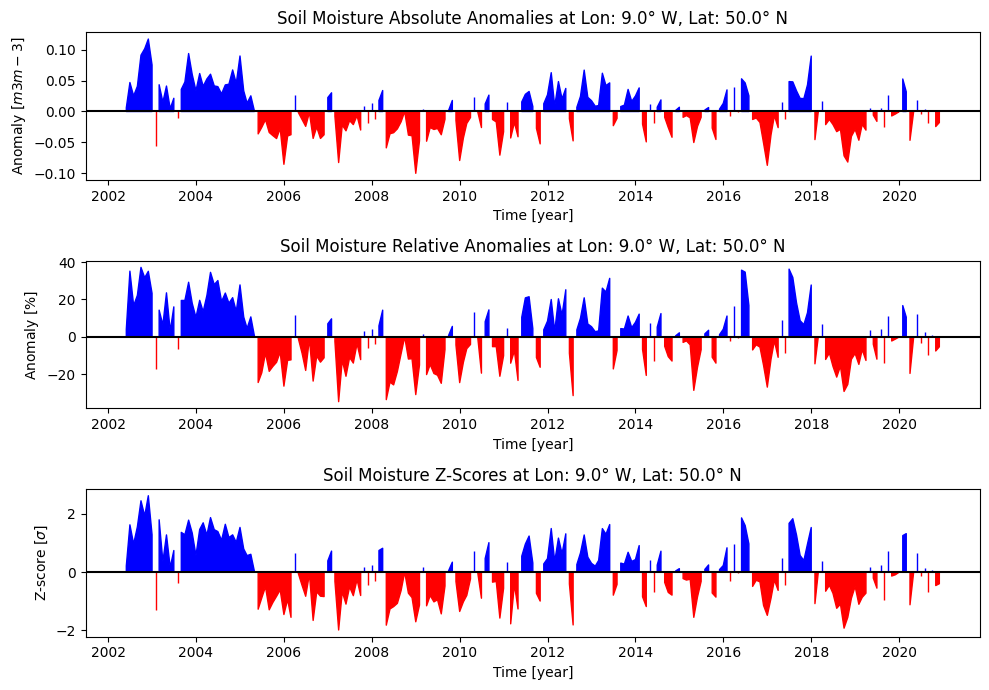

In [18]:
# Generate three time series plots for each anomaly metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 7))

for i, (metric, col, ylabel) in enumerate(zip(metrics, columns, ylabels)):
    axs[i].axhline(0, color="k")
    axs[i].fill_between(ts[col].index, ts[col].values, where=ts[col].values >= 0, color="blue")
    axs[i].fill_between(ts[col].index, ts[col].values, where=ts[col].values < 0, color="red")
    axs[i].set_ylabel(ylabel)
    axs[i].set_xlabel("Time [year]")
    axs[i].set_title(f"Soil Moisture {metric} at Lon: {lon}° W, Lat: {lat}° N")

plt.tight_layout()
plt.show()

Choosing a different study area will change the input data and plot anomalies for a different 'focus point'. You can also change the baseline period and see how it affects the climatology (and anomaly) computation. While the 3 time series look the same at first glance, there are some differences depending on the magnitude of the climatology and the intra-annual soil moisture variance in a point.

<a id='anomNd'></a>

## 6. **Application 3**: Vectorized Anomaly Computation
We will now compute the the anomalies for the whole image stack (not only on a time series basis as in the previous example). For this we use some of the functions provided by [xarray to group data](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html). For the climatology (reference) we use all data from 1991 to 2020 (`BASELINE_YEARS`). This is the standard baseline period, but you can of course try a different period. 

We will select all (absolute) soil moisture values in the reference period, group them by month (i.e. all January, February, ... values for all years in the baseline period) and compute the mean for each group. This way we get the `CLIM` stack, which consists of 12 images (one for each month):

In [19]:
BASELINE_YEARS = (1991, 2020)
STUDY_AREA = "Germany"

# select data in the climatology period and compute a monthly climatology stack
baseline_slice = slice(f"{BASELINE_YEARS[0]}-01-01", f"{BASELINE_YEARS[1]}-12-31")
CLIM = DS.sel(time=baseline_slice)["sm"].groupby(DS.sel(time=baseline_slice).time.dt.month).mean()

CLIM

<xarray.DataArray 'sm' (month: 12, lat: 152, lon: 204)> Size: 1MB
dask.array<stack, shape=(12, 152, 204), dtype=float32, chunksize=(1, 76, 102), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 608B 71.88 71.62 71.38 71.12 ... 34.62 34.38 34.12
  * lon      (lon) float32 816B -10.88 -10.62 -10.38 ... 39.38 39.62 39.88
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    dtype:            float32
    units:            m3 m-3
    valid_range:      [0. 1.]
    long_name:        Volumetric Soil Moisture
    _CoordinateAxes:  time lat lon

We can now use the climatology stack and compute the difference between each image of absolute soil moisture and the climatological mean of the same month. This way we compute the anomalies for the whole data cube, without a time-consuming loop over all individual locations. We assign the result to a new variable in the `DS` stack called `sm_anomaly`:

In [20]:
DS["sm_anomaly"] = DS["sm"] - CLIM.sel(month=DS.time.dt.month).drop("month")

We can use the bounding box of the chosen study area to extract all soil moisture values in the area of interest. We then compute the mean over all locations in the bounding box to get a single time series for the study area (`MEAN_TS`). Note that the coverage of C3S Soil Moisture varies over time (see the previous examples), which can also affect the value range of computed anomalies (standard deviation $\sigma$ is is usually larger for earlier periods).

In [21]:
subset = DS[["sm_anomaly"]].sel(
    lon=slice(BBOXES[STUDY_AREA][0][0], BBOXES[STUDY_AREA][0][1]),
    lat=slice(BBOXES[STUDY_AREA][0][3], BBOXES[STUDY_AREA][0][2]),
)
MEAN_TS = subset.mean(dim=["lat", "lon"]).to_pandas()

We will resample the monthly soil moisture values in `MEAN_TS` with an annual frequency ("A"):

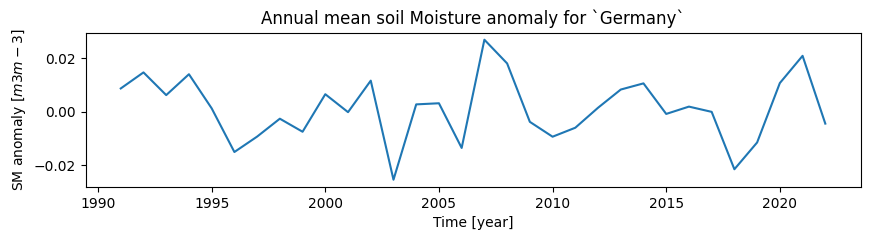

In [22]:
# Combine all data in the study area to an annual mean time series
mean_ts_annual = pd.Series(MEAN_TS["sm_anomaly"]).resample("A").mean()
mean_ts_annual.index = mean_ts_annual.index.year

# Create a plot to show the mean annual time series:
plt.figure(figsize=(10, 2))
mean_ts_annual.plot(
    title=f"Annual mean soil Moisture anomaly for `{STUDY_AREA}`",
    ylabel=f"SM anomaly $[{SM_UNIT}]$",
    xlabel="Time [year]",
)
plt.show()

Now we can visualize the monthly anomalies from the processed anomaly stack as a bar plot. We will also create a map of annual mean values using the created time series for the whole study area bounding box. This is done for the year assigned to the variable `YEAR` in the next cell.

Try:
- Plotting the annual anomalies for a different year (assign a different value to `YEAR` in the next cell).
- Changing `BASELINE_YEARS` in this application and see how the chosen period affects values in the map and time series.

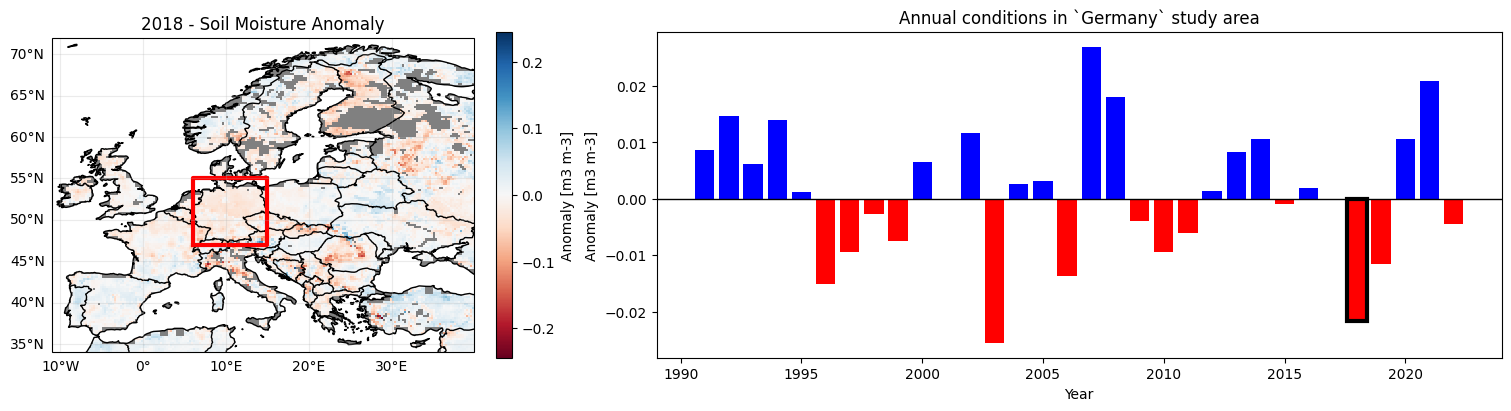

In [23]:
YEAR = 2018  # Choose a specific year to plot on the map

# Create a new figure with 2 subplots arranged in a 1:2 width ratio using GridSpec for flexible layout
fig = plt.figure(figsize=(15, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 3)
map_ax = fig.add_subplot(
    gs[0, 0], projection=ccrs.PlateCarree()
)  # Create the first subplot for the map
ts_ax = fig.add_subplot(gs[0, 1:])  # Create the second subplot for the time series


### Creating the soil moisture anomaly map for the chosen year:

# Select all soil moisture anomaly data for the chosen year, compute the average, and plot it on the map
DS["sm_anomaly"].sel(time=slice(f"{YEAR}-01-01", f"{YEAR}-12-31")).mean("time").plot(
    transform=ccrs.PlateCarree(),
    ax=map_ax,
    cmap=plt.get_cmap("RdBu"),
    cbar_kwargs={"label": f"Anomaly [{SM_UNIT}]"},
)

# Add geographical features to the map for better context
map_ax.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor="gray")  # Add land features
map_ax.axes.coastlines()  # Add coastlines
map_ax.add_feature(cartopy.feature.BORDERS)  # Add country borders
map_ax.set_title(f"{YEAR} - Soil Moisture Anomaly")  # Set the title of the map subplot

# Plot the bounding box of the study area on the map
bbox = BBOXES[STUDY_AREA][0]
map_ax.plot(
    [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
    [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
    color="red",
    linewidth=3,
    transform=ccrs.PlateCarree(),
)

# Add grid lines to the map
gl = map_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.25)
gl.right_labels, gl.top_labels = False, False


### Creating the soil moisture anomaly time series plot:

# Plot the annual time series of soil moisture anomaly for the study area as a bar plot
bars = ts_ax.bar(mean_ts_annual.index, mean_ts_annual.values)
ts_ax.set_title(f"Annual conditions in `{STUDY_AREA}` study area")
ts_ax.set_xlabel("Year")
ts_ax.set_ylabel(f"Anomaly [{SM_UNIT}]")
ts_ax.axhline(y=0, color="black", linewidth=1)

# Highlight the bar corresponding to the selected year and color bars based on the sign of the anomaly
for i, bar in enumerate(bars.patches):
    if mean_ts_annual.values[i] > 0:
        bar.set_facecolor("blue")  # Color positive anomalies blue
    else:
        bar.set_facecolor("red")  # Color negative anomalies red
    if mean_ts_annual.index.values[i] == YEAR:
        bar.set_edgecolor("k")  # Highlight the selected year's bar with a black edge
    bar.set_linewidth(3)

plt.show()

We see an overall trend towards drier conditions in most regions. You can look at a different study area by selecting it in the first application. Don't forget to re-run all relevant cells in this chapter to use the new study area and accordingly update the plots!